In [1]:
from argopy import DataFetcher as ArgoDataFetcher
import numpy as np
import matplotlib.pyplot as plt
import seawater as sw
from scipy.optimize import curve_fit

In [3]:
ds = ArgoDataFetcher().region([-25, -15, 58, 62, 0, 1000, '2010-01', '2020-12']).to_xarray()
ds = ds.argo.point2profile().argo.interp_std_levels(np.arange(0,1000))

In [23]:
dsm = ds.groupby("TIME.season").mean("N_PROF").sel(season="DJF")
dsm = dsm.assign(PDEN=("PRES_INTERPOLATED",sw.pden(dsm.PSAL,dsm.TEMP,dsm.PRES_INTERPOLATED)))
dsm = dsm.assign(B=-(9.82/1025)*dsm.PDEN)
dsm = dsm.rolling(PRES_INTERPOLATED=50,min_periods=1).mean()

In [24]:
def func(z, a, b, c,d,e):
    return a * np.tanh(b*(z-c)) + d*z + e

In [25]:
popt, pcov = curve_fit(func, dsm.PRES_INTERPOLATED.values, dsm.PDEN.values,p0=[0.2,6e-3,500,0,1027.6])
dsm = dsm.assign(PDENf=("PRES_INTERPOLATED",func(dsm.PRES_INTERPOLATED.values,*popt)))
dsm = dsm.assign(Bf=-(9.82/1025)*dsm.PDENf)

In [26]:
f"{popt[0]:.2f} tanh({popt[1]:.04f}(z-{popt[2]:.01f})) {popt[3]*1e5:.1f}z/100000 + {popt[4]:.2f}"

'0.25 tanh(0.0027(z-653.3)) -6.8z/100000 + 1027.56'

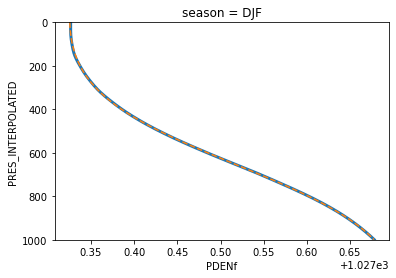

In [27]:
fig,ax = plt.subplots()
_ = dsm.PDEN.plot.line(y="PRES_INTERPOLATED",ylim=[1000,0],lw=3)
_ = dsm.PDENf.plot.line(y="PRES_INTERPOLATED",ylim=[1000,0],linestyle="--")
# plt.plot(func(dsm.PRES_INTERPOLATED,0.25,0.0027,653.3,-6.8e-5,1027.56),dsm.PRES_INTERPOLATED)

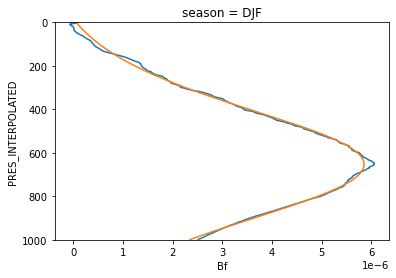

In [28]:
(-dsm.B.differentiate("PRES_INTERPOLATED")).plot(y="PRES_INTERPOLATED",ylim=[1000,0])
(-dsm.Bf.differentiate("PRES_INTERPOLATED")).plot(y="PRES_INTERPOLATED",ylim=[1000,0])

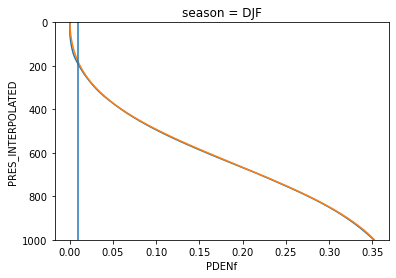

In [29]:
fig,ax = plt.subplots()
(dsm.PDEN-dsm.PDEN.sel(PRES_INTERPOLATED=0)).plot.line(y="PRES_INTERPOLATED",ylim=[1000,0])
(dsm.PDENf-dsm.PDENf.sel(PRES_INTERPOLATED=0)).plot.line(y="PRES_INTERPOLATED",ylim=[1000,0])
ax.axvline(0.01)